In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
mobile_modelling = pd.read_csv('../Data/Data_modelling/mobile_modelling.csv')

X = mobile_modelling.iloc[:, 0:-1]
y = mobile_modelling.iloc[:, -1]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

mobile_df = pd.concat([X_train, y_train], axis=1)

# variables with importance of more than 0.02 
columns_to_drop_1 = ['touch_screen', 'blue', 'dual_sim', 'four_g', 'wifi', 'three_g']
X_train_r = X_train.drop(columns=columns_to_drop_1)
X_val_r = X_val.drop(columns=columns_to_drop_1)


# Ensemble methods

## Bagging (Bootstrap Aggregating)
designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It decreases the variance and helps to avoid overfitting. It is usually applied to decision tree methods

we're testing Bagging method with two tree models - DecisionTreeClassifier and RandomForestClassifier

in 2 variants: with all the columns and with columns having importance greater than 0.02

In [4]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize

In [5]:

# Creating 2 models
model_dt = DecisionTreeClassifier(random_state=42)
model_rf = RandomForestClassifier(random_state=42)

# Bagging for first model
bagging_model_dt = BaggingClassifier(estimator=model_dt, n_estimators=10, random_state=42)
bagging_model_dt.fit(X_train, y_train)

bagging_model_dt_r = BaggingClassifier(estimator=model_dt, n_estimators=10, random_state=42)
bagging_model_dt_r.fit(X_train_r, y_train)

# Bagging for second model
bagging_model_rf = BaggingClassifier(estimator=model_rf, n_estimators=10, random_state=42)
bagging_model_rf.fit(X_train, y_train)

bagging_model_rf_r = BaggingClassifier(estimator=model_rf, n_estimators=10, random_state=42)
bagging_model_rf_r.fit(X_train_r, y_train)

# Checking probabilities on validation datasets
probabilities_model_dt = bagging_model_dt.predict_proba(X_val)
probabilities_model_dt_r = bagging_model_dt_r.predict_proba(X_val_r)
probabilities_model_rf = bagging_model_rf.predict_proba(X_val)
probabilities_model_rf_r = bagging_model_rf_r.predict_proba(X_val_r)

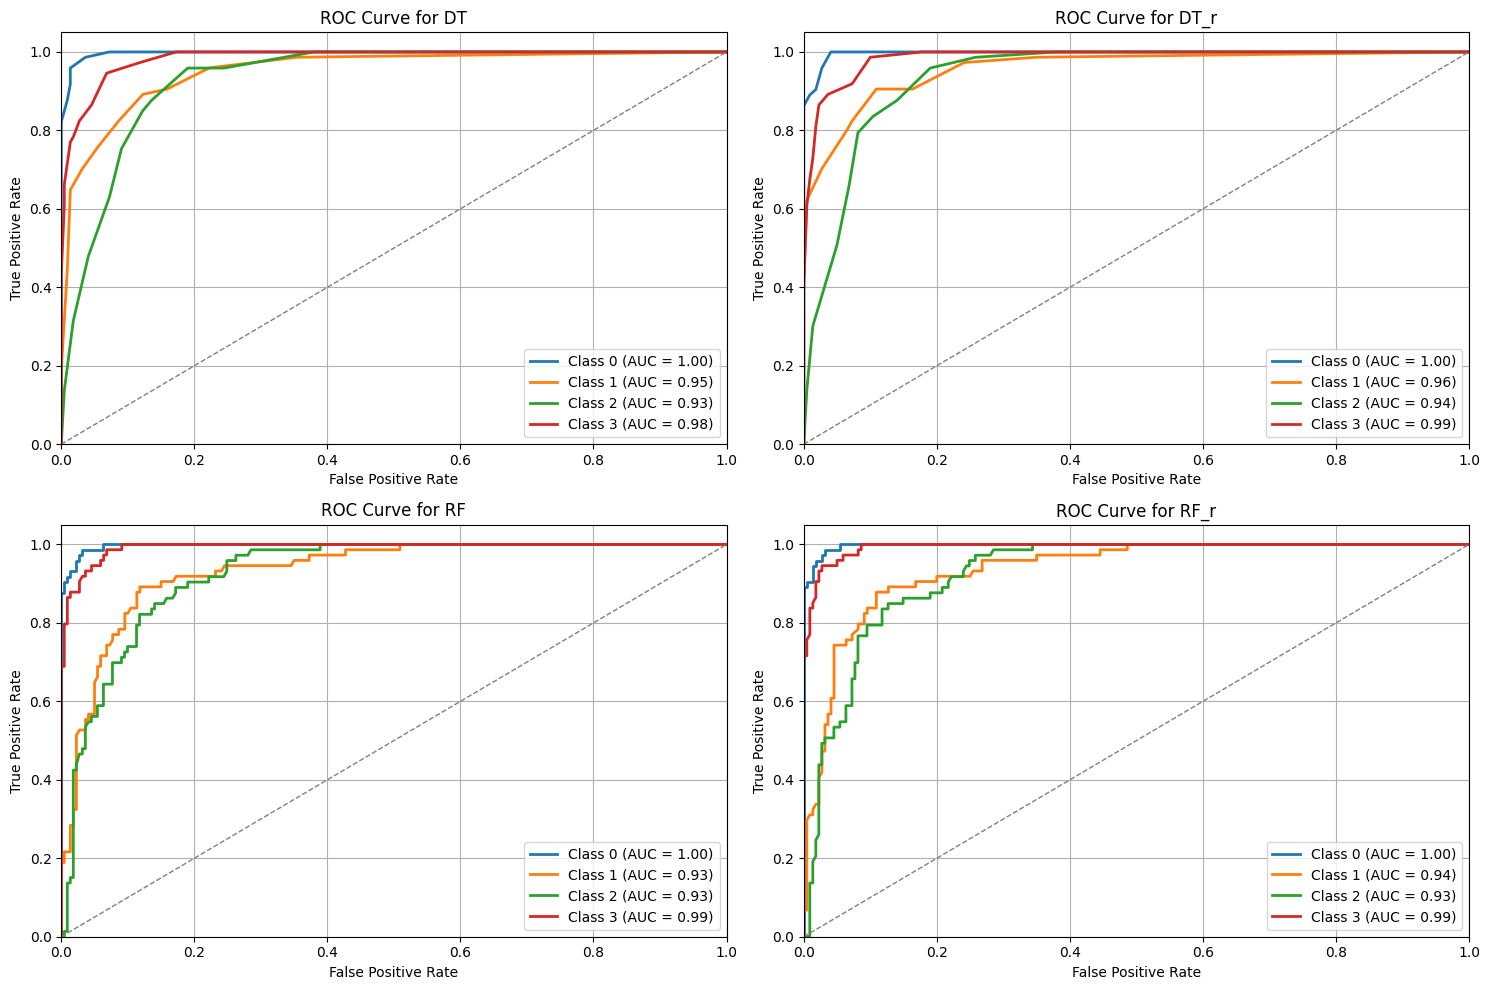

In [6]:
# Convert labels to binary format
y_val_binarized = label_binarize(y_val, classes=np.unique(y_val))
n_classes = y_val_binarized.shape[1]

# Initialize subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

models = [probabilities_model_dt, probabilities_model_dt_r, probabilities_model_rf, probabilities_model_rf_r]
model_names = ['DT', 'DT_r', 'RF', 'RF_r']

for idx, (model, model_name) in enumerate(zip(models, model_names)):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_val_binarized[:, i], model[:, i])
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    ax.legend(loc='lower right')
    ax.grid(True)

plt.tight_layout()
plt.show()


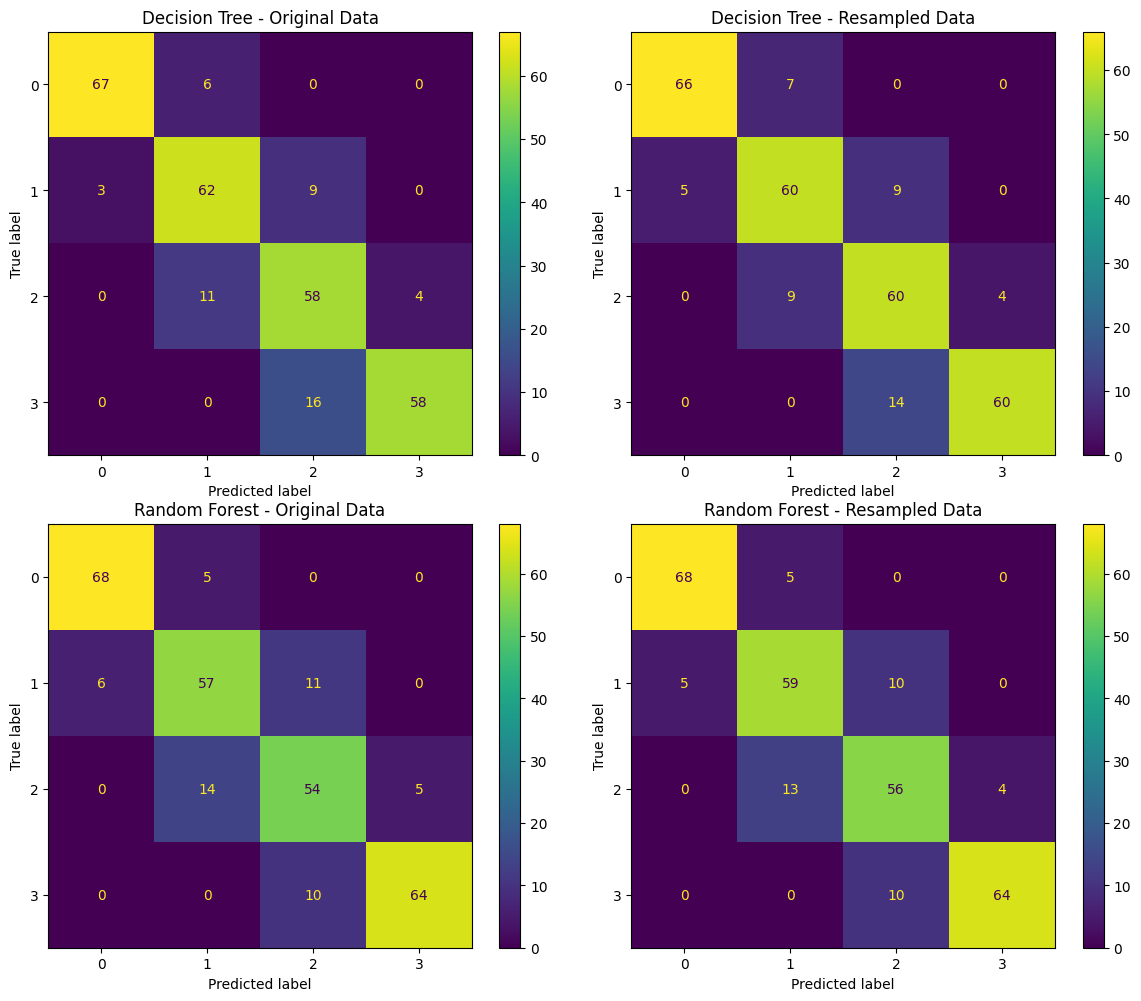

In [10]:
# Calculate confusion matrices
cm_model_dt = confusion_matrix(y_val, np.argmax(probabilities_model_dt, axis=1))
cm_model_dt_r = confusion_matrix(y_val, np.argmax(probabilities_model_dt_r, axis=1))
cm_model_rf = confusion_matrix(y_val, np.argmax(probabilities_model_rf, axis=1))
cm_model_rf_r = confusion_matrix(y_val, np.argmax(probabilities_model_rf_r, axis=1))

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_model_dt, display_labels=np.unique(y_val))
disp_dt.plot(ax=axes[0, 0])
axes[0, 0].set_title("Decision Tree - Original Data")

disp_dt_r = ConfusionMatrixDisplay(confusion_matrix=cm_model_dt_r, display_labels=np.unique(y_val))
disp_dt_r.plot(ax=axes[0, 1])
axes[0, 1].set_title("Decision Tree - Reduced Data")

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_model_rf, display_labels=np.unique(y_val))
disp_rf.plot(ax=axes[1, 0])
axes[1, 0].set_title("Random Forest - Original Data")

disp_rf_r = ConfusionMatrixDisplay(confusion_matrix=cm_model_rf_r, display_labels=np.unique(y_val))
disp_rf_r.plot(ax=axes[1, 1])
axes[1, 1].set_title("Random Forest - Reduced Data")

plt.tight_layout()
plt.show()

In [10]:
predictions_model_dt = bagging_model_dt.predict(X_val)
predictions_model_dt_r = bagging_model_dt_r.predict(X_val_r)
predictions_model_rf = bagging_model_rf.predict(X_val)
predictions_model_rf_r = bagging_model_rf_r.predict(X_val_r)

# Printing classification report
print("Bagging with DecisionTreeClassifier - all columns")
print(classification_report(y_val, predictions_model_dt))

print("Bagging with DecisionTreeClassifier - important columns")
print(classification_report(y_val, predictions_model_dt_r))

print("\nBagging with RandomForestClassifier - all columns")
print(classification_report(y_val, predictions_model_rf))

print("\nBagging with RandomForestClassifier - important columns")
print(classification_report(y_val, predictions_model_rf_r))

Bagging with DecisionTreeClassifier - all columns
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        73
           1       0.78      0.84      0.81        74
           2       0.70      0.79      0.74        73
           3       0.94      0.78      0.85        74

    accuracy                           0.83       294
   macro avg       0.84      0.83      0.84       294
weighted avg       0.84      0.83      0.84       294

Bagging with DecisionTreeClassifier - important columns
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        73
           1       0.79      0.81      0.80        74
           2       0.72      0.82      0.77        73
           3       0.94      0.81      0.87        74

    accuracy                           0.84       294
   macro avg       0.84      0.84      0.84       294
weighted avg       0.84      0.84      0.84       294


Bagging with RandomFore

## Boosting
we're checking Boosting method with:
    AdaBoost
    XGBoost
    CatBoost

in 2 variants: with all the columns and with columns having importance greater than 0.02

In [24]:
#!pip install xgboost
#!pip install catboost

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [12]:
# Function for training and evaluating the model
def train_and_evaluate_model(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print(classification_report(y_val, predictions))

# Modeling with AdaBoost for all columns
print("AdaBoost for all columns:")
ada_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
train_and_evaluate_model(ada_model, X_train, X_test, y_train, y_test)

# Modeling with AdaBoost for selected columns
print("\nAdaBoost for selected columns:")
train_and_evaluate_model(ada_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with XGBoost for all columns
print("\nXGBoost for all columns:")
xgb_model = XGBClassifier(random_state=42)
train_and_evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

# Modeling with XGBoost for selected columns
print("\nXGBoost for selected columns:")
train_and_evaluate_model(xgb_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with CatBoost for all columns
print("\nCatBoost for all columns:")
cat_model = CatBoostClassifier(random_state=42, verbose=0)
train_and_evaluate_model(cat_model, X_train, X_test, y_train, y_test)

# Modeling with CatBoost for selected columns
print("\nCatBoost for selected columns:")
train_and_evaluate_model(cat_model, X_train_r, X_val_r, y_train, y_val)


AdaBoost for all columns:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81        32
           1       0.66      0.68      0.67        31
           2       0.40      0.72      0.52        32
           3       0.33      0.13      0.19        31

    accuracy                           0.56       126
   macro avg       0.58      0.56      0.54       126
weighted avg       0.58      0.56      0.55       126


AdaBoost for selected columns:
              precision    recall  f1-score   support

           0       0.88      0.58      0.69        73
           1       0.60      0.74      0.67        74
           2       0.41      0.68      0.52        73
           3       0.41      0.19      0.26        74

    accuracy                           0.55       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.58      0.55      0.53       294


XGBoost for all columns:
              precision    recall  f1-score   

### Boosting methods with visualisations

AdaBoost for all columns:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81        32
           1       0.66      0.68      0.67        31
           2       0.40      0.72      0.52        32
           3       0.33      0.13      0.19        31

    accuracy                           0.56       126
   macro avg       0.58      0.56      0.54       126
weighted avg       0.58      0.56      0.55       126



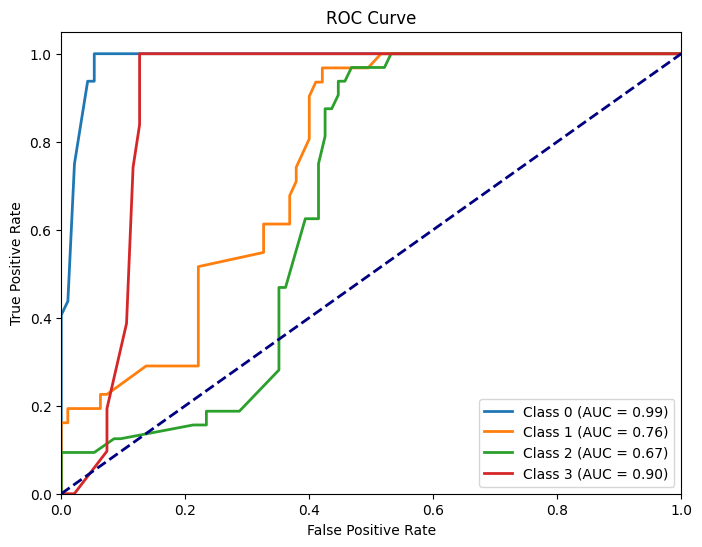

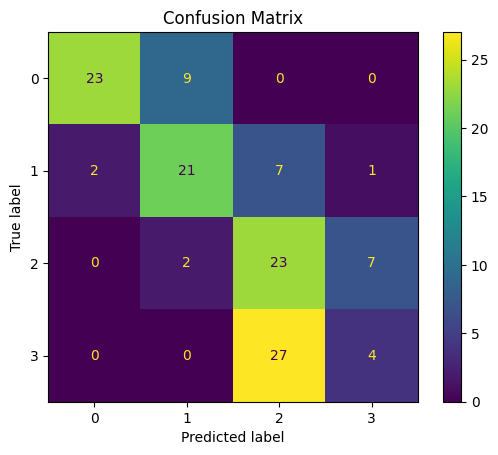


AdaBoost for selected columns:
              precision    recall  f1-score   support

           0       0.88      0.58      0.69        73
           1       0.60      0.74      0.67        74
           2       0.41      0.68      0.52        73
           3       0.41      0.19      0.26        74

    accuracy                           0.55       294
   macro avg       0.58      0.55      0.53       294
weighted avg       0.58      0.55      0.53       294



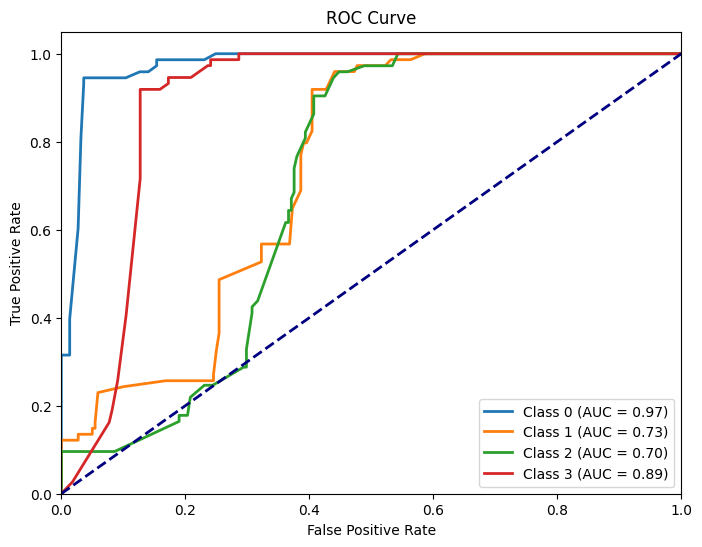

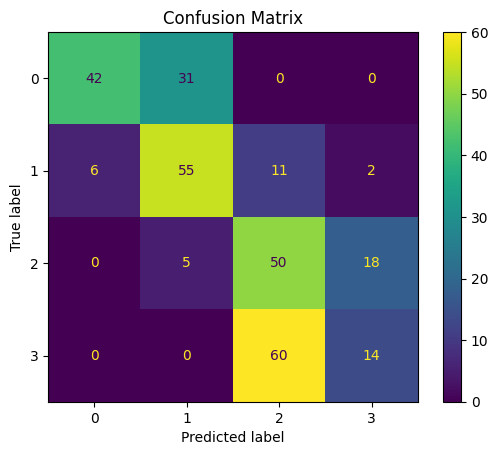


XGBoost for all columns:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.87      0.87      0.87        31
           2       0.91      0.91      0.91        32
           3       0.97      1.00      0.98        31

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



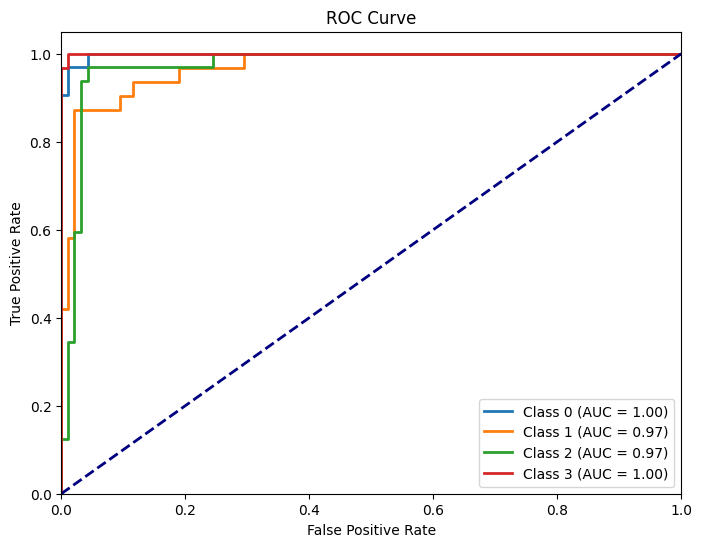

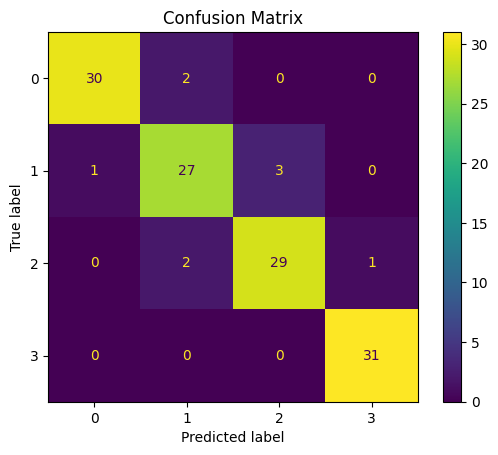


XGBoost for selected columns:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        73
           1       0.86      0.88      0.87        74
           2       0.84      0.85      0.84        73
           3       0.95      0.93      0.94        74

    accuracy                           0.90       294
   macro avg       0.90      0.90      0.90       294
weighted avg       0.90      0.90      0.90       294



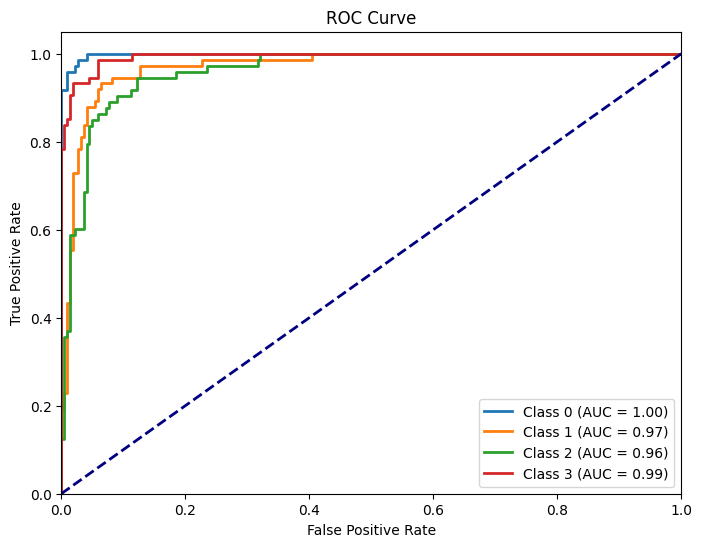

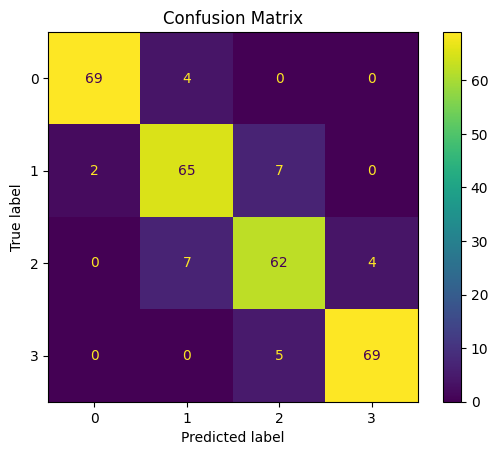


CatBoost for all columns:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        32
           1       0.90      0.84      0.87        31
           2       0.88      0.94      0.91        32
           3       0.97      1.00      0.98        31

    accuracy                           0.93       126
   macro avg       0.93      0.93      0.93       126
weighted avg       0.93      0.93      0.93       126



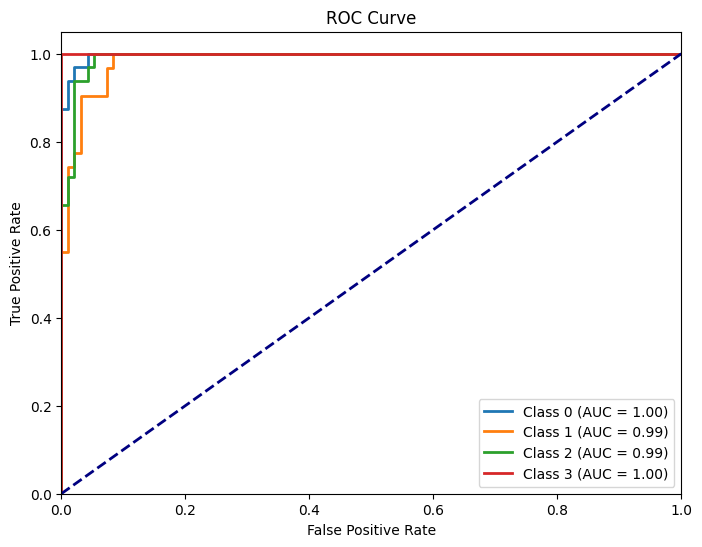

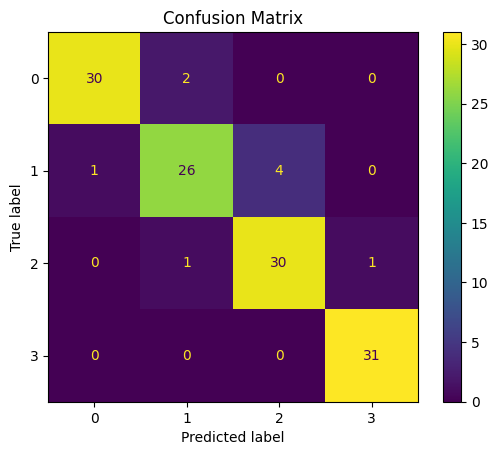


CatBoost for selected columns:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        73
           1       0.89      0.92      0.91        74
           2       0.85      0.88      0.86        73
           3       0.96      0.92      0.94        74

    accuracy                           0.92       294
   macro avg       0.92      0.92      0.92       294
weighted avg       0.92      0.92      0.92       294



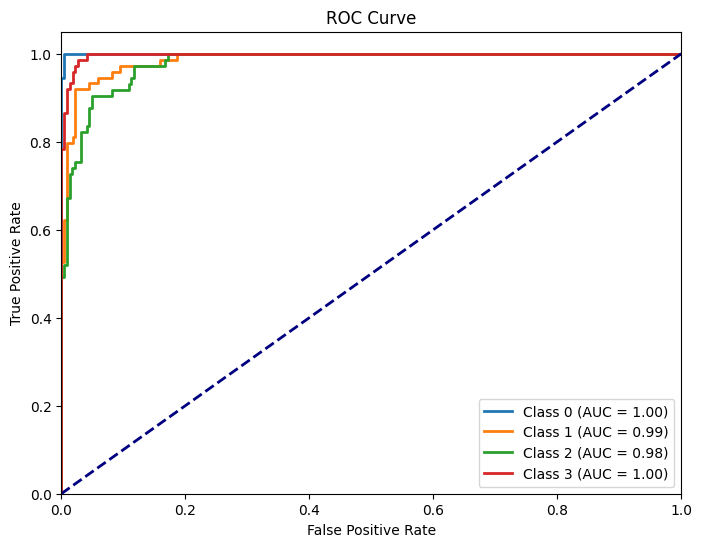

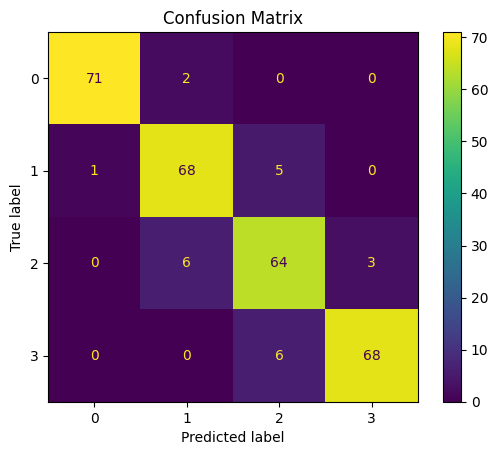

In [17]:
# Function for training, evaluating the model, and plotting ROC curve
def train_and_evaluate_model_with_ROC(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    print(classification_report(y_val, predictions))
    
    # Binarize the labels for ROC curve
    if len(np.unique(y_train)) > 2:
        y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
        y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
    else:
        y_train_bin = y_train
        y_val_bin = y_val

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if len(np.unique(y_train)) > 2:
        for i in range(len(np.unique(y_train))):
            fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], model.predict_proba(X_val)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr, tpr, _ = roc_curve(y_val_bin, model.predict_proba(X_val)[:, 1])
        roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    if len(np.unique(y_train)) > 2:
        for i in range(len(np.unique(y_train))):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')
    else:
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:0.2f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Plot confusion matrix
    cm = confusion_matrix(y_val, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

# Modeling with AdaBoost for all columns
print("AdaBoost for all columns:")
ada_model = AdaBoostClassifier(random_state=42, algorithm='SAMME')
train_and_evaluate_model_with_ROC(ada_model, X_train, X_test, y_train, y_test)

# Modeling with AdaBoost for selected columns
print("\nAdaBoost for selected columns:")
train_and_evaluate_model_with_ROC(ada_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with XGBoost for all columns
print("\nXGBoost for all columns:")
xgb_model = XGBClassifier(random_state=42)
train_and_evaluate_model_with_ROC(xgb_model, X_train, X_test, y_train, y_test)

# Modeling with XGBoost for selected columns
print("\nXGBoost for selected columns:")
train_and_evaluate_model_with_ROC(xgb_model, X_train_r, X_val_r, y_train, y_val)

# Modeling with CatBoost for all columns
print("\nCatBoost for all columns:")
cat_model = CatBoostClassifier(random_state=42, verbose=0)
train_and_evaluate_model_with_ROC(cat_model, X_train, X_test, y_train, y_test)

# Modeling with CatBoost for selected columns
print("\nCatBoost for selected columns:")
train_and_evaluate_model_with_ROC(cat_model, X_train_r, X_val_r, y_train, y_val)


# Bayes optimization

In [1]:
! pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/107.7 kB ? eta -:--:--
   ---------------------- ----------------- 61.4/107.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 107.7/107.7 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   ----------------------------------- ---- 122.9/138.7 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 138.7/138.7 kB 1.6 MB/s eta 0:00:00


### SVM

In [21]:
from skopt import BayesSearchCV
from sklearn.svm import SVC

opt = BayesSearchCV(
    SVC(),
    {
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=10,
    cv=3
)

opt.fit(X_train, y_train)

print("best score on train set: %s" % opt.best_score_)
print("score on validation set: %s" % opt.score(X_val, y_val))

best score on train set: 0.9653070924247825
score on validation set: 0.9693877551020408


### Random Forest Classifier

In [22]:
# Define the optimizer with BayesSearchCV
opt_rf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': (10, 1000),  # Number of trees in the forest
        'max_depth': (1, 20),  # Maximum depth of the tree
        'min_samples_split': (2, 10),  # Minimum number of samples required to split a node
        'min_samples_leaf': (1, 10),  # Minimum number of samples required at each leaf node
        'max_features': (1, len(X_train.columns)),  # Number of features to consider when looking for the best split
    },
    n_iter=10,  # Number of optimization iterations
    cv=3
)

# Fit the optimizer to the training data
opt_rf.fit(X_train, y_train)

# Print the best validation score for Random Forest
print("best score on train set: %s" % opt_rf.best_score_)

# Print the test score for Random Forest
print("score on validation set: %s" % opt_rf.score(X_val, y_val))

best score on train set: 0.8530921871384528
score on validation set: 0.8571428571428571


### Decision Tree Classifier

In [23]:
# Define the optimizer with BayesSearchCV
opt_dt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1, 20),  # Maximum depth of the tree
        'min_samples_split': (2, 10),  # Minimum number of samples required to split a node
        'min_samples_leaf': (1, 10),  # Minimum number of samples required at each leaf node
        'max_features': (1, len(X_train.columns)),  # Number of features to consider when looking for the best split
    },
    n_iter=10,  # Number of optimization iterations
    cv=3
)

# Fit the optimizer to the training data
opt_dt.fit(X_train, y_train)

# Print the best validation score for Decision Tree
print("best score on train set: %s" % opt_dt.best_score_)

# Print the test score for Decision Tree
print("score on validation set: %s" % opt_dt.score(X_val, y_val))

best score on train set: 0.8051099729210834
score on validation set: 0.8231292517006803


# XAI - TODO